In [55]:
import basicpy
from basicpy import datasets
from matplotlib import pyplot as plt
from skimage import io
from subprocess import check_output

In [3]:
images = datasets.wsi_brain()

In [6]:
io.imsave("testdata_for_imagej/wsi_brain.tif", images)

In [56]:
filename="/work/fukai/basicpy/BaSiCPy/misc_notebooks/analysis_for_publication/testdata_for_imagej/wsi_brain.tif"
res = check_output(["/opt/Fiji.app/ImageJ-linux64", "--headless", "--run", "imagej_macro.py", 
     f"\"filename='{filename}'\""
])

OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
[ERROR] Ignoring extraneous argument: org.scijava.parse.DefaultParseService$ItemsList$1@2ecf5915


In [60]:
res.decode().split("\n")

['Reading IFDs',
 'Populating metadata',
 'Checking comment style',
 'Populating OME metadata',
 "array('i', [128, 128, 1, 1, 63])",
 'Compute spatial shading profiles...',
 'Reweighting Iteration:1',
 'Stop Criterion1  0.6578910228434837',
 'Stop Criterion2  0.19582470609293806',
 'Stop Criterion3  0.182095171813429',
 'Stop Criterion4  0.14231235158225475',
 'Stop Criterion5  0.11803738802340531',
 'Stop Criterion6  0.10513283026654732',
 'Stop Criterion7  0.09947532647082245',
 'Stop Criterion8  0.09714822196119456',
 'Stop Criterion9  0.09563015543742236',
 'Stop Criterion10  0.0935269975474165',
 'Stop Criterion11  0.0797147791023047',
 'Stop Criterion12  0.05548833928513054',
 'Stop Criterion13  0.0380605742941605',
 'Stop Criterion14  0.030888658338720662',
 'Stop Criterion15  0.024735341357409284',
 'Stop Criterion16  0.018273114875286007',
 'Stop Criterion17  0.012494727530884394',
 'Stop Criterion18  0.008144474673490349',
 'Stop Criterion19  0.00523136819421288',
 'Stop Crit

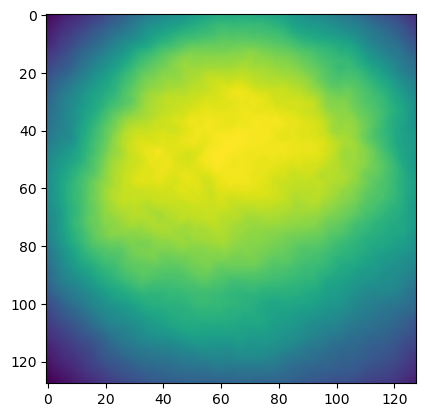

In [52]:
flatfield = io.imread("testdata_for_imagej/wsi_brain_flatfield.tif")
plt.imshow(flatfield)

In [57]:
b = basicpy.BaSiC(fitting_mode="approximate",get_darkfield=True)
b.fit(images)

In [48]:
import jax
_ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])

In [49]:
b.fit(images)